In [ ]:

'''
from google.colab import drive
drive.mount('/content/drive')
import sys    
import os
path_to_module = '/content/drive/MyDrive/247project/'
sys.path.append(path_to_module)
os.chdir(path_to_module)
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import torch
import numpy as np

# get the device, either cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device type is {}'.format(device))

device type is cuda


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_test = X_test[:, :, 0:500];
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
X_train_valid = X_train_valid[:, :, 0:500]
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 500)
Test data shape: (443, 22, 500)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
#extract subject1
idx = np.argwhere(person_train_valid == 1)[:, 0]
X_train_valid_1 = X_train_valid[idx, :, :]
y_train_valid_1 = y_train_valid[idx]

idx = np.argwhere(person_test == 1)[:, 0]
X_test_1 = X_test[idx, :, :]
y_test_1 = y_test[idx]

print(y_test_1.shape)

(50,)


In [ ]:
def normalize(array):
  return (array - np.mean(array, axis=0)) / np.std(array, axis=0)
#preprocess data
#X_train_valid = normalize(X_train_valid)
#X_test = normalize(X_test)
y_train_valid -= 769
y_test -= 769
X_train_valid_1 = normalize(X_train_valid_1)
X_test_1 = normalize(X_test_1)
y_train_valid_1 -= 769
y_test_1 -= 769

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)
X_train_valid_prep_1,y_train_valid_prep_1 = data_prep(X_train_valid_1,y_train_valid_1,2,2,True)
X_test_1,y_test_1 = data_prep(X_test_1,y_test_1,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of X after trimming: (236, 22, 500)
Shape of X after maxpooling: (236, 22, 250)
Shape of X after averaging+noise and concatenating: (472, 22, 250)
Shape of X after subsampling and concatenating: (944, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)


In [ ]:
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)


In [ ]:
# First generating the training and validation indices using random splitting of subject 1
ind_valid = np.random.choice(944, 150, replace=False)
ind_train = np.array(list(set(range(944)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train_1, x_valid_1) = X_train_valid_prep_1[ind_train], X_train_valid_prep_1[ind_valid] 
(y_train_1, y_valid_1) = y_train_valid_prep_1[ind_train], y_train_valid_prep_1[ind_valid]
print('Shape of training set:',x_train_1.shape)
print('Shape of validation set:',x_valid_1.shape)
print('Shape of training labels:',y_train_1.shape)
print('Shape of validation labels:',y_valid_1.shape)

Shape of training set: (794, 22, 250)
Shape of validation set: (150, 22, 250)
Shape of training labels: (794,)
Shape of validation labels: (150,)


In [ ]:
#train valid split for preprocessing data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


extract test data for each subject 0~8

In [ ]:
idx = np.argwhere(person_test == 1)[:, 0]
X_test_1 = X_test[idx, :, :]
y_test_1 = y_test[idx]

X_test_sp = {}
y_test_sp = {}
for i in np.arange(9):
  idx = np.argwhere(person_test == i)[:, 0]
  X_test_sp[i] = X_test[idx, :, :]
  y_test_sp[i] = y_test[idx]

  X_test_sp[i], y_test_sp[i] = data_prep(X_test_sp[i],y_test_sp[i],2,2,True)
  print(X_test_sp[i].shape)

Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
(200, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
(200, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
(200, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
(200, 22, 250)
Shape of X after trimming: (47, 22, 500)
Shape of X after maxpooling: (47, 22, 250)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
trainset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).type(torch.LongTensor))
validset = TensorDataset(torch.from_numpy(x_valid).float(), torch.from_numpy(y_valid).type(torch.LongTensor))
testset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).type(torch.LongTensor))
trainset_1 = TensorDataset(torch.from_numpy(x_train_1).float(), torch.from_numpy(y_train_1).type(torch.LongTensor))
validset_1 = TensorDataset(torch.from_numpy(x_valid_1).float(), torch.from_numpy(y_valid_1).type(torch.LongTensor))
testset_1 = TensorDataset(torch.from_numpy(X_test_1).float(), torch.from_numpy(y_test_1).type(torch.LongTensor))

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
validloader_1 = DataLoader(validset_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_1 = DataLoader(testset_1, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
#testloader for each subject with preprocessing
testset_sp = {}
testloader_sp = {}

for i in np.arange(9):
  testset_sp[i] = TensorDataset(torch.from_numpy(X_test_sp[i]).float(), torch.from_numpy(y_test_sp[i]).type(torch.LongTensor))
  testloader_sp[i] = DataLoader(testset_sp[i], batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
batch_size = 64

testset_prep = TensorDataset(torch.from_numpy(X_test_prep).float(), torch.from_numpy(y_test_prep).type(torch.LongTensor))


testloader_prep = DataLoader(testset_prep, batch_size=batch_size, shuffle=True, num_workers=2)


In [ ]:
import torch.nn as nn # torch neural network modules
class swap(nn.Module):
  def forward(self, x):
    return torch.transpose(x, 1, 2)
class extractcell(nn.Module):
  def forward(self, x):
    out, (hn, cn) = x #out: (N, L=1000, hidden), hn: (#layers, N, hidden)

    return out#[:, :200, :] #(N, L=1000, hidden)

class extractlastcell(nn.Module):
  def forward(self, x):
    out, (hn, cn) = x #out: (N, L=1000, hidden), hn: (#layers, N, hidden)

    return out[:, -1, :] #(N, hidden)

class choosebegin(nn.Module):
  def forward(self, x):
    return x[:, :100, :] 

class NeuralNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential( #(N, 1000, 22)
            swap(),

            nn.LSTM(22, 25, batch_first=True),
            extractcell(),
            swap(),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(25),
            nn.Dropout(0.5),

            swap(),
            nn.LSTM(25, 50, batch_first=True),
            extractcell(),
            swap(),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            
            swap(),
            nn.LSTM(50, 100, batch_first=True),
            extractcell(),
            swap(),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            
            #swap(),
            #nn.LSTM(100, 200, batch_first=True),
            #extractcell(),
            #swap(),
            #nn.MaxPool1d(3, padding=1),
            #nn.BatchNorm1d(200),
            #nn.Dropout(0.5),

            nn.Flatten(),
            nn.Linear(3800, 4)
            
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

model = NeuralNet().to(device)

In [ ]:
class NeuralNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential( #(N, 1000, 22)

            nn.Flatten(),
            #asd()
            nn.Linear(22000, 4)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

model = NeuralNet().to(device)

In [ ]:
import torch.nn as nn # torch neural network modules
class NeuralNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential( #(N, 1000, 22)
            
            nn.Conv1d(22, 25, 10, padding='same'),#(N, 1000, 25)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 334, 25)
            nn.BatchNorm1d(25),
            nn.Dropout(0.5),

            #swap(),
            #nn.LSTM(22, 25, batch_first=True),
            #extractcell(),
            #swap(),
            #nn.MaxPool1d(3, padding=1),
            #nn.BatchNorm1d(25),
            #nn.Dropout(0.5),

            nn.Conv1d(25, 50, 10, padding='same'),#(N, 334, 50)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 112, 50)
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
          
            nn.Conv1d(50, 100, 10, padding='same'),#(N, 112, 100)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 38, 100)
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),

            nn.Conv1d(100, 200, 10, padding='same'),#(N, 38, 200)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 13, 200)
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),

            #nn.Conv1d(200, 400, 10, padding='same'),
            #nn.ELU(),
            #nn.MaxPool1d(3, padding=1),
            #nn.BatchNorm1d(400),
            #nn.Dropout(0.5),

            swap(),
            nn.LSTM(200, 400, batch_first=True),
            extractcell(),
            swap(),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(400),
            nn.Dropout(0.5),

            swap(),
            nn.LSTM(400, 800, batch_first=True),
            extractcell(),
            swap(),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(800),
            nn.Dropout(0.5),

            nn.Flatten(),
            nn.Linear(800, 4)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

model = NeuralNet().to(device)

In [ ]:
import torch.nn as nn # torch neural network modules
class NeuralNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential( #(N, 1000, 22)
            
            nn.Conv1d(22, 25, 10, padding='same'),#(N, 1000, 25)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 334, 25)
            nn.BatchNorm1d(25),
            nn.Dropout(0.5),

            nn.Conv1d(25, 50, 10, padding='same'),#(N, 334, 50)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 112, 50)
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),

            nn.Conv1d(50, 100, 10, padding='same'),#(N, 112, 100)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 38, 100)
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.Conv1d(100, 200, 10, padding='same'),#(N, 38, 200)
            nn.ELU(),
            nn.MaxPool1d(3, padding=1),#(N, 13, 200)
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),

            #nn.Conv1d(200, 400, 10, padding='same'),
            #nn.ELU(),
            #nn.MaxPool1d(3, padding=1),
            #nn.BatchNorm1d(400),
            #nn.Dropout(0.5),

            nn.Flatten(),
            nn.Linear(800, 4)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

model = NeuralNet().to(device)

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(tr_set, val_set, model, device):

    n_epochs = 50
    best_val_acc = 0
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)#0.001
    
    loss_record = []
    val_loss_record = []
    acc_record = {'train':[], 'valid':[]}
    for epoch in range(n_epochs):
        model.train()
        loss_epoch = []
        val_loss_epoch = []
        #running_loss = 0.0
        for data in tr_set:
            optimizer.zero_grad()
            x, y = data
            #xv, yv = v_data
            #xv, yv = xv.to(device), yv.to(device)
            x, y = x.to(device), y.to(device)
            pred = model(x)
            #vpred = model(xv)
            loss = model.cal_loss(pred, y)
            loss.backward()
            optimizer.step()
            #val_loss = model.cal_loss(vpred, yv)

            #val_loss_epoch.append(val_loss.item())
            loss_epoch.append(loss.item())

        #val_loss_record.append(sum(val_loss_epoch)/len(val_loss_epoch))
        loss_record.append(sum(loss_epoch)/len(loss_epoch))
        acc_train = test(tr_set, model, device)
        acc_valid = test(val_set, model, device)
        if acc_valid>best_val_acc:
          best_val_acc = acc_valid
          best_model = model
        acc_record['train'].append(acc_train)
        acc_record['valid'].append(acc_valid)
        print('Finished training after {} epochs'.format(epoch+1))
        print('acc on valid set:{}'.format(acc_valid))
    #plt.subplot(2, 1, 1)
    plt.title('Training loss')
    plt.plot(loss_record, '-', label='train')
    #plt.plot(val_loss_record, '-', label='valid')
    plt.xlabel('epochs')
    plt.show()
    plt.title('Accuracy')
    plt.plot(acc_record['train'], '-', label='train')
    plt.plot(acc_record['valid'], '-', label='valid')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    #plt.gcf().set_size_inches(15, 12)
    plt.show()

    model = best_model


In [ ]:
def test(tt_set, model, device):
    correct = total = 0
    model.eval()
    for x, y in tt_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred = model(x)
        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    acc = correct / total
    return acc

Finished training after 1 epochs
acc on valid set:0.4
Finished training after 2 epochs
acc on valid set:0.4533333333333333
Finished training after 3 epochs
acc on valid set:0.52
Finished training after 4 epochs
acc on valid set:0.52
Finished training after 5 epochs
acc on valid set:0.5866666666666667
Finished training after 6 epochs
acc on valid set:0.6
Finished training after 7 epochs
acc on valid set:0.6933333333333334
Finished training after 8 epochs
acc on valid set:0.6933333333333334
Finished training after 9 epochs
acc on valid set:0.6933333333333334
Finished training after 10 epochs
acc on valid set:0.7733333333333333
Finished training after 11 epochs
acc on valid set:0.8
Finished training after 12 epochs
acc on valid set:0.84
Finished training after 13 epochs
acc on valid set:0.8
Finished training after 14 epochs
acc on valid set:0.8933333333333333
Finished training after 15 epochs
acc on valid set:0.9
Finished training after 16 epochs
acc on valid set:0.9133333333333333
Finish

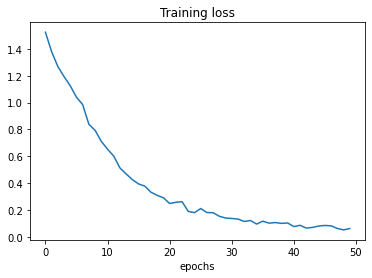

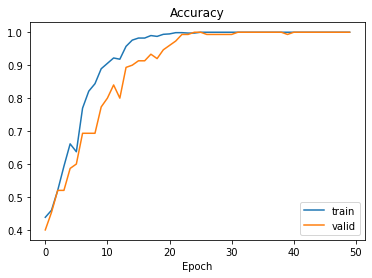

In [ ]:
train(trainloader_1, validloader_1, model, device)

In [ ]:
acc_test = test(testloader_prep, model, device)

print('acc on test set:{}'.format(acc_test))

acc on test set:0.32223476297968395


In [ ]:
PATH = './prep_cnn.pth'

# Save:
torch.save(model.state_dict(), PATH) # save state_dict

In [ ]:
PATH = './prep_cnn.pth'
re_model = NeuralNet()
re_model.load_state_dict(torch.load(PATH)) # load state_dict
re_model.eval() # sets model in evaluation (inference) mode

NeuralNet(
  (net): Sequential(
    (0): Conv1d(22, 25, kernel_size=(10,), stride=(1,), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(25, 50, kernel_size=(10,), stride=(1,), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(50, 100, kernel_size=(10,), stride=(1,), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (13): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv1d(100, 200, kernel_size=(10,

In [ ]:
#test on each subjects
for i in np.arange(9):
  acc_test = test(testloader_sp[i], model, device)
  print('acc on test set:{}'.format(acc_test))

acc on test set:0.605
acc on test set:0.585
acc on test set:0.805
acc on test set:0.695
acc on test set:0.8191489361702128
acc on test set:0.6632653061224489
acc on test set:0.735
acc on test set:0.76
acc on test set:0.8031914893617021
